# Задача 4. Ансамбли (Bagging, Random Forest, Boosting)


In [1]:

import numpy as np
import pandas as pd

from time import perf_counter

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, log_loss,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier, RandomForestClassifier,
    AdaBoostClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:

X, y = make_classification(
    n_samples=10_000,     
    n_features=5,
    n_informative=3,
    n_redundant=2,
    n_classes=2,
    weights=[0.65, 0.35], 
    class_sep=1.2,
    flip_y=0.02,
    random_state=RANDOM_STATE
)

df = pd.DataFrame(X, columns=[f"f{i:02d}" for i in range(X.shape[1])])
df["target"] = y
df.head()


,f00,f01,f02,f03,f04,target
0,-0.713100,-2.601372,2.691637,-0.623250,-1.919862,0
1,-0.416861,-0.065555,-0.195679,1.452191,0.770546,1
2,1.218562,1.249094,0.546103,-1.967572,-1.905496,0
3,0.411861,1.372550,1.194108,2.166679,-1.175525,1
4,0.500278,0.205339,-0.623792,-2.120155,-0.184634,0


In [3]:

df.describe().T.head(10)


,count,mean,std,min,25%,50%,75%,max
f00,10000.0,0.386287,0.650320,-1.858348,-0.057182,0.421879,0.814638,2.558894
f01,10000.0,0.430306,1.382337,-4.735272,-0.475608,0.877035,1.394268,4.318704
f02,10000.0,0.412856,1.349648,-3.974084,-0.434789,0.351446,1.198276,6.579959
f03,10000.0,-0.366936,1.607813,-6.319712,-1.533177,-0.522635,0.826582,5.375913
f04,10000.0,-0.789218,1.366939,-5.207187,-1.693093,-0.948854,0.031837,3.993118
target,10000.0,0.353000,0.477927,0.000000,0.000000,0.000000,1.000000,1.000000


target
0    6470
1    3530
Name: count, dtype: int64

target
0    0.647
1    0.353
Name: count, dtype: float64

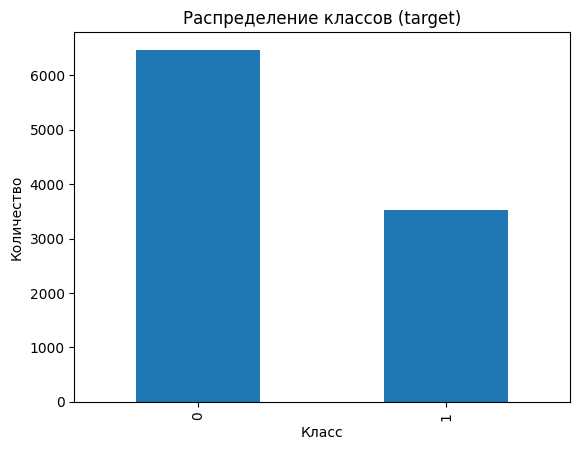

In [4]:

class_counts = df["target"].value_counts()
class_ratio = class_counts / len(df)
display(class_counts, class_ratio)

plt.figure()
class_counts.plot(kind="bar")
plt.title("Распределение классов (target)")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.show()


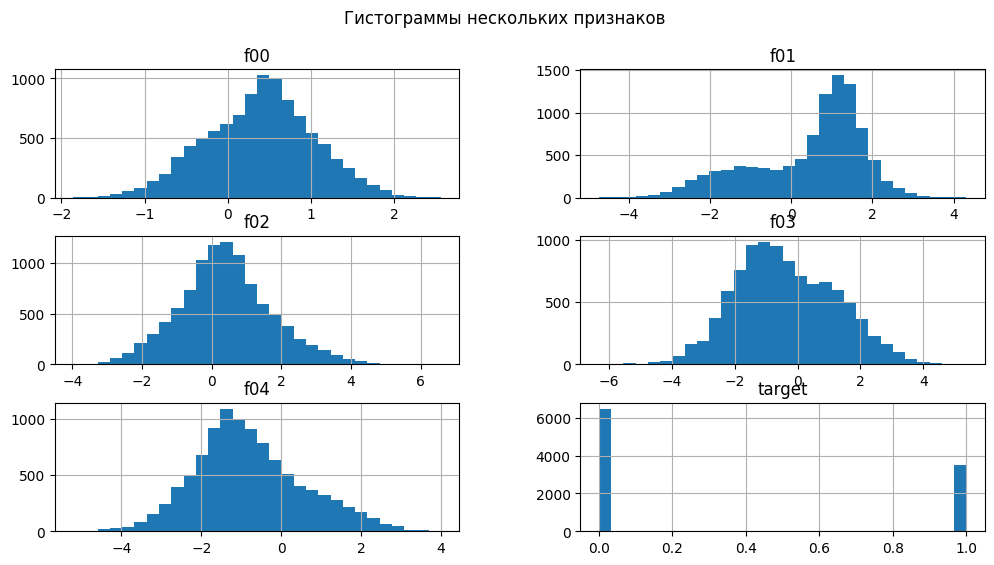

In [5]:
cols = df.columns[:6]
df[cols].hist(bins=30, figsize=(12, 6))
plt.suptitle("Гистограммы нескольких признаков")
plt.show()


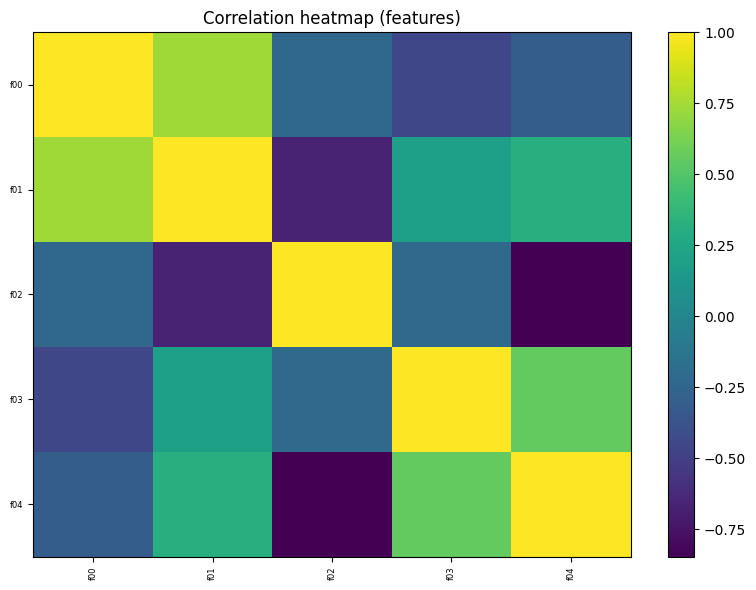

In [6]:

corr = df.drop(columns=["target"]).corr(numeric_only=True)

plt.figure(figsize=(8, 6))
plt.imshow(corr, aspect="auto")
plt.title("Correlation heatmap (features)")
plt.colorbar()
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=6)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.tight_layout()
plt.show()


In [7]:

X = df.drop(columns=["target"]).values
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

X_train.shape, X_test.shape


((7500, 5), (2500, 5))

### 3.1. Bagging


In [8]:

class MyBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=50, max_samples=1.0, random_state=None):
        self.base_estimator = base_estimator if base_estimator is not None else DecisionTreeClassifier(max_depth=3)
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.random_state = random_state

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        n = X.shape[0]
        m = int(np.ceil(self.max_samples * n)) if isinstance(self.max_samples, float) else int(self.max_samples)
        m = max(1, min(m, n))

        self.estimators_ = []
        self.classes_ = np.unique(y)

        for _ in range(self.n_estimators):
            idx = rng.randint(0, n, size=m)
            est = clone(self.base_estimator)
            est.fit(X[idx], y[idx])
            self.estimators_.append(est)

        return self

    def predict_proba(self, X):
        probs = []
        for est in self.estimators_:
            if hasattr(est, "predict_proba"):
                probs.append(est.predict_proba(X))
            else:
                pred = est.predict(X)
                onehot = np.zeros((X.shape[0], len(self.classes_)))
                for j, c in enumerate(self.classes_):
                    onehot[:, j] = (pred == c).astype(float)
                probs.append(onehot)
        return np.mean(probs, axis=0)

    def predict(self, X):
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]


### 3.2. AdaBoost (SAMME)


In [9]:

class MyAdaBoostSAMME(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=100, learning_rate=1.0, random_state=None):
        self.base_estimator = base_estimator if base_estimator is not None else DecisionTreeClassifier(max_depth=1)
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.random_state = random_state

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        n = X.shape[0]
        self.classes_ = np.unique(y)
        K = len(self.classes_)
        if K < 2:
            raise ValueError("Need at least 2 classes.")

        w = np.ones(n, dtype=float) / n
        self.estimators_ = []
        self.estimator_weights_ = []

        for _ in range(self.n_estimators):
            est = clone(self.base_estimator)
            if hasattr(est, "random_state"):
                est.set_params(random_state=rng.randint(0, 10_000_000))
            est.fit(X, y, sample_weight=w)

            y_pred = est.predict(X)
            incorrect = (y_pred != y).astype(float)
            err = np.dot(w, incorrect) / np.sum(w)

            if err <= 0:
                self.estimators_.append(est)
                self.estimator_weights_.append(1.0)
                break

            if err >= 1 - (1 / K):
                break

            alpha = self.learning_rate * (np.log((1 - err) / err) + np.log(K - 1))
            w *= np.exp(alpha * incorrect)
            w /= np.sum(w)

            self.estimators_.append(est)
            self.estimator_weights_.append(alpha)

        self.estimator_weights_ = np.array(self.estimator_weights_, dtype=float)
        return self

    def predict_proba(self, X):
        K = len(self.classes_)
        scores = np.zeros((X.shape[0], K), dtype=float)
        for est, alpha in zip(self.estimators_, self.estimator_weights_):
            pred = est.predict(X)
            for k, c in enumerate(self.classes_):
                scores[:, k] += alpha * (pred == c).astype(float)

        scores -= scores.max(axis=1, keepdims=True)
        exp_scores = np.exp(scores)
        return exp_scores / exp_scores.sum(axis=1, keepdims=True)

    def predict(self, X):
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]


## 4. Оценка качества и скорости

In [10]:

def fit_time_and_model(estimator, X_train, y_train):
    t0 = perf_counter()
    estimator.fit(X_train, y_train)
    t1 = perf_counter()
    return t1 - t0, estimator

def evaluate_classifier(model, X_test, y_test, model_name="model"):
    t0 = perf_counter()
    y_pred = model.predict(X_test)
    t1 = perf_counter()
    pred_time = t1 - t0

    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)
        y_proba = 1 / (1 + np.exp(-scores))

    metrics = {
        "model": model_name,
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "pred_time_sec": pred_time,
    }

    if y_proba is not None:
        metrics["roc_auc"] = roc_auc_score(y_test, y_proba)
        proba2 = np.vstack([1 - y_proba, y_proba]).T
        metrics["log_loss"] = log_loss(y_test, proba2)
    else:
        metrics["roc_auc"] = np.nan
        metrics["log_loss"] = np.nan

    return metrics, y_pred


## 5. Подбор гиперпараметров + кросс-валидация (GridSearchCV)

In [11]:

stump = DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE)

my_bag = MyBaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                             random_state=RANDOM_STATE)

my_bag_params = {
    "n_estimators": [30, 80, 150],
    "max_samples": [0.5, 0.8, 1.0],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=2),
        DecisionTreeClassifier(max_depth=3),
        DecisionTreeClassifier(max_depth=4)
    ]
}

my_ada = MyAdaBoostSAMME(base_estimator=stump, random_state=RANDOM_STATE)

my_ada_params = {
    "n_estimators": [50, 150, 300],
    "learning_rate": [0.3, 0.7, 1.0],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2)
    ]
}

sk_bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE),
    random_state=RANDOM_STATE, n_jobs=-1
)

sk_bag_params = {
    "n_estimators": [50, 150],
    "max_samples": [0.6, 1.0],
    "estimator__max_depth": [2, 3, 4]
}

rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

rf_params = {
    "n_estimators": [200],
    "max_depth": [None, 8, 14],
    "min_samples_split": [2, 10],
    "max_features": ["sqrt", 0.5]
}

sk_ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE),
    algorithm="SAMME", random_state=RANDOM_STATE
)

sk_ada_params = {
    "n_estimators": [100, 300],
    "learning_rate": [0.3, 1.0],
    "estimator__max_depth": [1, 2]
}

gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

gb_params = {
    "n_estimators": [150, 300],
    "learning_rate": [0.05, 0.1],
    "max_depth": [2, 3]
}

hgb = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

hgb_params = {
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 6, None],
    "max_iter": [200, 400],
    "l2_regularization": [0.0, 0.1]
}

models_and_params = [
    ("MyBagging", my_bag, my_bag_params),
    ("MyAdaBoostSAMME", my_ada, my_ada_params),
    ("sklearn_Bagging", sk_bag, sk_bag_params),
    ("RandomForest", rf, rf_params),
    ("sklearn_AdaBoost", sk_ada, sk_ada_params),
    ("GradientBoosting", gb, gb_params),
    ("HistGradientBoosting", hgb, hgb_params),
]


In [12]:

search_results = []
best_models = {}

for name, model, params in models_and_params:
    print(f"\n=== {name} ===")
    gs = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring="f1",
        cv=cv,
        n_jobs=-1,
        verbose=0,
        refit=True,
    )

    t0 = perf_counter()
    gs.fit(X_train, y_train)
    t1 = perf_counter()

    print("best_params:", gs.best_params_)
    print("best_cv_f1:", round(gs.best_score_, 5))
    print("search_time_sec:", round(t1 - t0, 3))

    best_models[name] = gs.best_estimator_
    search_results.append({
        "model": name,
        "best_cv_f1": gs.best_score_,
        "search_time_sec": t1 - t0
    })

pd.DataFrame(search_results).sort_values("best_cv_f1", ascending=False)



=== MyBagging ===
best_params: {'base_estimator': DecisionTreeClassifier(max_depth=4), 'max_samples': 0.5, 'n_estimators': 150}
best_cv_f1: 0.91023
search_time_sec: 33.974

=== MyAdaBoostSAMME ===
best_params: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 1.0, 'n_estimators': 300}
best_cv_f1: 0.93531
search_time_sec: 38.166

=== sklearn_Bagging ===
best_params: {'estimator__max_depth': 4, 'max_samples': 0.6, 'n_estimators': 50}
best_cv_f1: 0.91249
search_time_sec: 16.858

=== RandomForest ===
best_params: {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
best_cv_f1: 0.95868
search_time_sec: 38.467

=== sklearn_AdaBoost ===


d:\Pycharn\spbu_ml_cuorse_iinod\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


best_params: {'estimator__max_depth': 2, 'learning_rate': 1.0, 'n_estimators': 300}
best_cv_f1: 0.93531
search_time_sec: 30.181

=== GradientBoosting ===
best_params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
best_cv_f1: 0.94635
search_time_sec: 36.654

=== HistGradientBoosting ===
best_params: {'l2_regularization': 0.0, 'learning_rate': 0.05, 'max_depth': None, 'max_iter': 200}
best_cv_f1: 0.95624
search_time_sec: 27.669


,model,best_cv_f1,search_time_sec
3,RandomForest,0.958675,38.467481
6,HistGradientBoosting,0.956240,27.668806
5,GradientBoosting,0.946346,36.653821
1,MyAdaBoostSAMME,0.935315,38.165559
4,sklearn_AdaBoost,0.935315,30.181258
2,sklearn_Bagging,0.912485,16.858026
0,MyBagging,0.910233,33.974117


## 6. eval


In [13]:

test_results = []
preds = {}

for name, model in best_models.items():
    fit_time, fitted = fit_time_and_model(clone(model), X_train, y_train)
    metrics, y_pred = evaluate_classifier(fitted, X_test, y_test, model_name=name)
    metrics["fit_time_sec"] = fit_time
    test_results.append(metrics)
    preds[name] = y_pred

results_df = pd.DataFrame(test_results).sort_values("f1", ascending=False)
results_df


d:\Pycharn\spbu_ml_cuorse_iinod\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


,model,accuracy,f1,pred_time_sec,roc_auc,log_loss,fit_time_sec
3,RandomForest,0.9656,0.950913,0.063391,0.983057,0.128139,0.906395
6,HistGradientBoosting,0.9612,0.944413,0.046912,0.982242,0.133488,0.682681
5,GradientBoosting,0.9560,0.937071,0.008937,0.978707,0.147600,6.920673
1,MyAdaBoostSAMME,0.9484,0.925563,0.066593,0.976848,0.168749,5.264864
4,sklearn_AdaBoost,0.9484,0.925563,0.061315,0.976848,0.539979,6.186395
0,MyBagging,0.9256,0.891355,0.075582,0.963775,0.209709,2.359752
2,sklearn_Bagging,0.9248,0.890443,0.040207,0.961979,0.213961,0.201601


,model,accuracy,f1,pred_time_sec,roc_auc,log_loss,fit_time_sec
0,RandomForest,0.9656,0.950913,0.063391,0.983057,0.128139,0.906395
1,HistGradientBoosting,0.9612,0.944413,0.046912,0.982242,0.133488,0.682681
2,GradientBoosting,0.9560,0.937071,0.008937,0.978707,0.147600,6.920673
3,MyAdaBoostSAMME,0.9484,0.925563,0.066593,0.976848,0.168749,5.264864
4,sklearn_AdaBoost,0.9484,0.925563,0.061315,0.976848,0.539979,6.186395
5,MyBagging,0.9256,0.891355,0.075582,0.963775,0.209709,2.359752
6,sklearn_Bagging,0.9248,0.890443,0.040207,0.961979,0.213961,0.201601


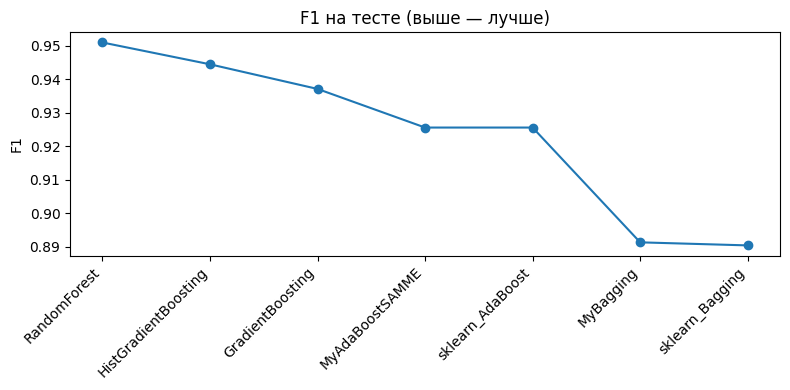

In [14]:

display(results_df.reset_index(drop=True))

plt.figure(figsize=(8, 4))
plt.plot(results_df["f1"].values, marker="o")
plt.xticks(range(len(results_df)), results_df["model"], rotation=45, ha="right")
plt.title("F1 на тесте (выше — лучше)")
plt.ylabel("F1")
plt.tight_layout()
plt.show()


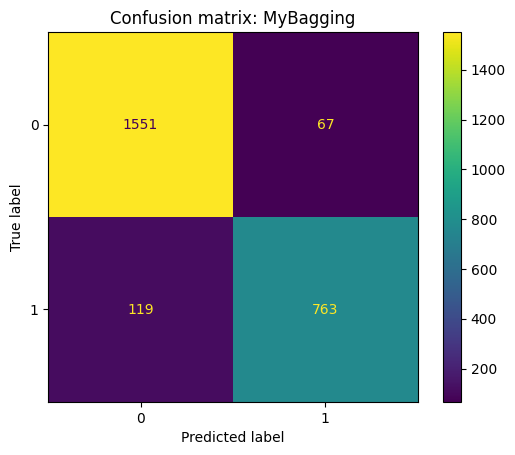

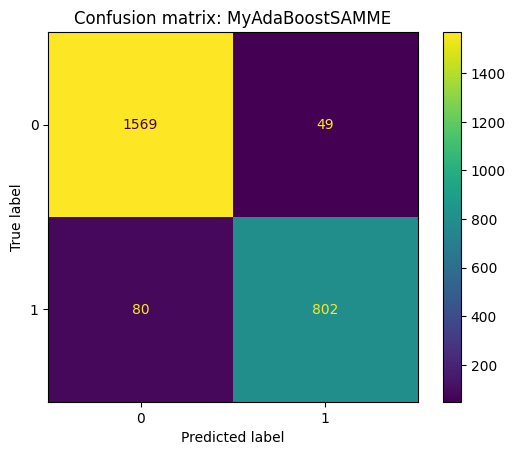

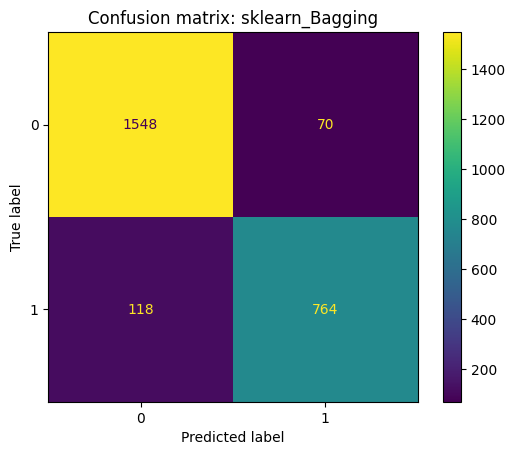

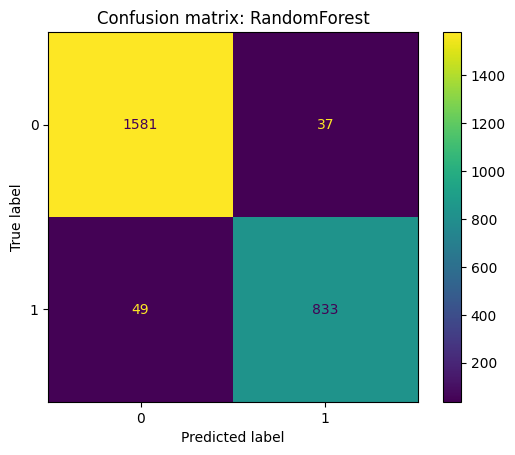

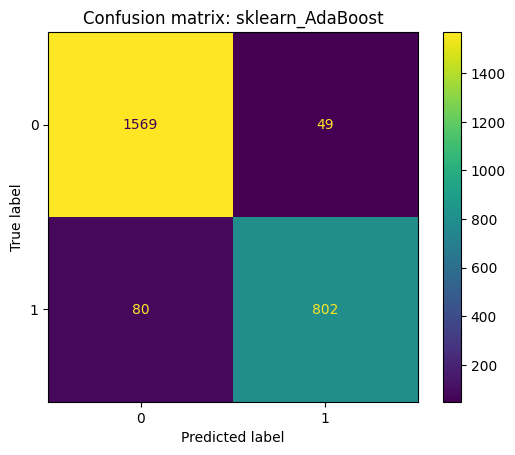

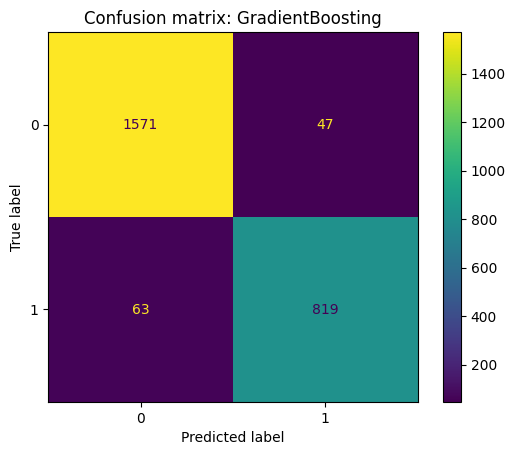

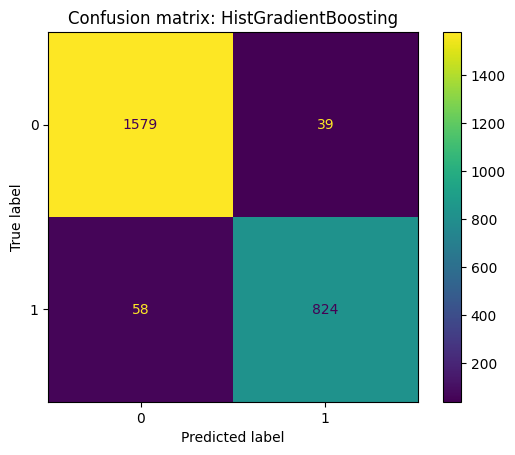

In [15]:

for name, y_pred in preds.items():
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(values_format="d")
    plt.title(f"Confusion matrix: {name}")
    plt.show()


In [16]:

best_name = results_df.iloc[0]["model"]
best_model = clone(best_models[best_name]).fit(X_train, y_train)

print("Лучшая модель:", best_name)
print(classification_report(y_test, best_model.predict(X_test)))


Лучшая модель: RandomForest
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1618
           1       0.96      0.94      0.95       882

    accuracy                           0.97      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.97      0.97      0.97      2500



## 7.XGBoost / LightGBM / CatBoost

In [17]:

extra_models = {}

from xgboost import XGBClassifier
extra_models["XGBoost"] = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="logloss"
)

from lightgbm import LGBMClassifier
extra_models["LightGBM"] = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

from catboost import CatBoostClassifier
extra_models["CatBoost"] = CatBoostClassifier(
    iterations=600,
    depth=6,
    learning_rate=0.05,
    loss_function="Logloss",
    verbose=False,
    random_seed=RANDOM_STATE
)

extra_models


{'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.9, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=400, n_jobs=-1,
               num_parallel_tree=None, ...),
 'LightGBM': LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, n_estimators=500,
                n_jobs=-1, num_leaves=63, random_state=42, subsample=0.9),
 'CatBoost': <catboost.core.CatBoostClas

In [18]:

extra_results = []

for name, model in extra_models.items():
    fit_time, fitted = fit_time_and_model(model, X_train, y_train)
    metrics, _ = evaluate_classifier(fitted, X_test, y_test, model_name=name)
    metrics["fit_time_sec"] = fit_time
    extra_results.append(metrics)

extra_df = pd.DataFrame(extra_results).sort_values("f1", ascending=False)
display(extra_df)



[LightGBM] [Info] Number of positive: 2648, number of negative: 4852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353067 -> initscore=-0.605586
[LightGBM] [Info] Start training from score -0.605586


d:\Pycharn\spbu_ml_cuorse_iinod\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Pycharn\spbu_ml_cuorse_iinod\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,model,accuracy,f1,pred_time_sec,roc_auc,log_loss,fit_time_sec
2,CatBoost,0.9644,0.949172,0.072456,0.983077,0.122593,3.616791
1,LightGBM,0.9632,0.947548,0.079338,0.981764,0.209194,0.739500
0,XGBoost,0.9628,0.946766,0.007004,0.981590,0.130078,0.427461


## 8. Optuna 

In [19]:
import optuna

d:\Pycharn\spbu_ml_cuorse_iinod\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:

from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_categorical("max_depth", [None, 3, 5, 8]),
        "max_iter": trial.suggest_int("max_iter", 150, 700),
        "l2_regularization": trial.suggest_float("l2_regularization", 0.0, 1.0),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 10, 100),
        "random_state": RANDOM_STATE,
    }
    model = HistGradientBoostingClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best F1 (CV):", study.best_value)
print("Best params:", study.best_params)

best_optuna_model = HistGradientBoostingClassifier(**study.best_params, random_state=RANDOM_STATE)
fit_time, fitted = fit_time_and_model(best_optuna_model, X_train, y_train)
metrics, _ = evaluate_classifier(fitted, X_test, y_test, model_name="HGB_Optuna")
metrics["fit_time_sec"] = fit_time
display(pd.DataFrame([metrics]))


[I 2025-12-20 21:15:30,655] A new study created in memory with name: no-name-bb0ce16f-61ad-48e9-ac6f-719e48b98f22
[I 2025-12-20 21:15:31,093] Trial 0 finished with value: 0.9442834406145805 and parameters: {'learning_rate': 0.09442826958021959, 'max_depth': 3, 'max_iter': 161, 'l2_regularization': 0.4538767076959441, 'min_samples_leaf': 67}. Best is trial 0 with value: 0.9442834406145805.
[I 2025-12-20 21:15:33,123] Trial 1 finished with value: 0.9530131512596437 and parameters: {'learning_rate': 0.02498753121062672, 'max_depth': 5, 'max_iter': 659, 'l2_regularization': 0.07036958363807588, 'min_samples_leaf': 21}. Best is trial 1 with value: 0.9530131512596437.
[I 2025-12-20 21:15:34,112] Trial 2 finished with value: 0.9539234831953026 and parameters: {'learning_rate': 0.08618370654586177, 'max_depth': 5, 'max_iter': 336, 'l2_regularization': 0.854274037810651, 'min_samples_leaf': 48}. Best is trial 2 with value: 0.9539234831953026.
[I 2025-12-20 21:15:36,574] Trial 3 finished with va

Best F1 (CV): 0.9552308322933489
Best params: {'learning_rate': 0.07638185702242953, 'max_depth': None, 'max_iter': 498, 'l2_regularization': 0.5501105075950631, 'min_samples_leaf': 26}


,model,accuracy,f1,pred_time_sec,roc_auc,log_loss,fit_time_sec
0,HGB_Optuna,0.9632,0.947668,0.110549,0.981861,0.164204,1.928842
